## cdef class callback vs cython ode vs python ode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import rand_mat
from scipy.integrate import odeint
%load_ext cython

In [ ]:
from math import sin
def ode_py(x_t, t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

In [ ]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cpdef np.ndarray[DTYPE_t, ndim=1] ode_cp(double[::1] x_t, double t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

## KalmanODE & KalmanODE_py

In [2]:
from KalmanTest.KalmanODE_py import KalmanODE_py
from probDE.cython.KalmanTest.KalmanODE import KalmanODE

In [ ]:
# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 50
n_eval = n_steps-1
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, a, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([-1., 0., 1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

In [ ]:
# Python
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
x0_state = kalmanode_py.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_sim, kalman_py_mu, kalman_py_var = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

# Cython
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
x0_state = kalmanode.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_sim, kalman_mu, kalman_var = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
tseq = np.linspace(tmin, tmax, n_steps)
plt.plot(tseq, kalman_py_sim[:, 0], label = 'Python mean')
plt.plot(tseq, kalman_sim[:, 0], label = 'C mean')
plt.legend(loc='upper left')

In [ ]:
kalman_cy = %timeit -o -n 100 _, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py = %timeit -o -n 100 _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py.average/kalman_cy.average

## Lorenz63

In [ ]:
def lorenz0(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y

In [ ]:
# RHS of ODE
def lorenz(X_t, t, theta=None):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    p = 3
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_var = 3 # Number of variates
n_meas = 1
n_state = 3 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 5000 
n_eval = n_steps -1
tmin = 0
tmax = 20

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 1
sigma = .001
sigmalst = [sigma]*n_var
scale = 10 # Scaling factor for root generation

# Initial value, a, for the IVP
x0 = [-12, -5, 38]
v0 = lorenz0(x0, 0)
a = np.column_stack([x0, v0])
z_states = rand_mat(2*n_steps, n_var*n_state)



In [ ]:
# Python
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
x0_state = kalmanode_py.multi_initialize(w_mat, tau, sigmalst, a, scale) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_lor_sim, kalman_py_lor_mu, kalman_py_lor_var = kalmanode_py.solve(x0_state, mv=True, sim=True) 

# Cython
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, a, scale) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_lor_sim, kalman_lor_mu, kalman_lor_var = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
tseq = np.linspace(tmin, tmax, n_steps)
_, axs = plt.subplots(n_var, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(n_var):
    axs[i].plot(tseq, kalman_py_lor_sim[:, n_state*i], label="Python")
    axs[i].plot(tseq, kalman_lor_sim[:, n_state*i], label="C")
    axs[i].set_ylabel(ylabel[i])
    axs[i].legend(loc='upper left')

In [ ]:
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lor_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lor_py.average/kalman_lor_cy.average

## Lane-Emden

In [3]:
def lane0(x_t, t):
    return [x_t[1], -2/t*x_t[1] - x_t[0]]

In [4]:
def lane(x_t, t, theta=None):
    return np.array([-2/t*x_t[1] - x_t[0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 500
n_eval = n_steps-1 
tmin = 1
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, a, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([1., 0., -1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

In [ ]:
# Python
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
x0_state = kalmanode_py.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_lane_sim, kalman_py_lane_mu, kalman_py_lane_var = kalmanode_py.solve(x0_state, mv=True, sim=True)

# Cython
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
x0_state = kalmanode.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_lane_sim, kalman_lane_mu, kalman_lane_var = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
tseq = np.linspace(tmin, tmax, n_steps)
lane_odeint = odeint(lane0, [1, 0], tseq)
plt.plot(tseq, kalman_py_lane_sim[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_lane_sim[:, 1], label = 'C++ mean')
plt.plot(tseq, lane_odeint[:, 1], label = 'Odeint mean')
plt.legend(loc='upper left')

In [ ]:
kalman_lane_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py.average/kalman_lane_cy.average

## FitzHugh-Nagumo

In [5]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

In [6]:
# RHS of ODE
def fitz(X_t, t, theta):
    p = 3
    a, b, c = theta
    V, R = X_t[p*0], X_t[p*1]
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

def fitz_initialize(n_steps, theta):
    # LHS Matrix of ODE
    w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

    # These parameters define the order of the ODE and the CAR(p) process
    n_var = 2 # Number of variates
    n_meas = 1 
    n_state = 3 # number of continuous derivatives of CAR(p) solution prior

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    n_eval = n_steps -1
    tmin = 0
    tmax = 20

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    tau = 100
    sigma = .001
    sigmalst = [sigma]*n_var

    # Initial value, a, for the IVP
    x0 = [-1, 1]
    v0 = fitz0(x0, 0, theta)
    a = np.column_stack([x0, v0])
    z_states = rand_mat(2*n_steps, n_var*n_state)
    
    # Initialize the class
    kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, fitz)
    x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, a) # Get the initial x0_state using initialize method
    kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
    return kalmanode, x0_state

def fitz_simulate(n_steps, theta):
    kalmanode, x0_state = fitz_initialize(n_steps, theta)
    kalman_fitz_mu, kalman_fitz_var = kalmanode.solve(x0_state, theta=theta, mv=True, sim=False)
    return kalman_fitz_mu, kalman_fitz_var

In [7]:
def normal_loglik(mu, sigma, y):
    n_steps = len(y) 
    loglik =-n_steps/2*(np.log(2*np.pi)- np.sum(np.log(sigma*sigma))) - \
        0.5*np.sum((y - mu)**2/(sigma*sigma))
    return loglik

In [8]:
def fitz_mwg(n_samples, y, theta0, rwsd, accept=False):
    # Get problem dimensions and initialization
    n_theta = len(theta0)
    n_steps = len(y)
    x0 = [-1, 1]
    theta_prop = np.zeros((n_samples*n_theta, n_theta)) 
    theta_curr = theta0
    paccept = np.zeros(n_theta, dtype=int)
    
    # MCMC process
    kalmanode, x0_state = fitz_initialize(n_steps, theta_curr)
    mu_curr, var_curr = kalmanode.solve(x0_state, theta=theta_curr, mv=True, sim=False)
    lp_curr = normal_loglik(mu_curr[1:, 0], var_curr[1:, 0, 0], y[1:, 0])
    for i in range(n_samples):
        for j in range(n_theta):
            theta_prop[i*n_theta+j] = theta_curr
            theta_prop[i*n_theta+j, j] += rwsd[j]*np.random.randn()
            if theta_prop[i*n_theta+j, 2]>0:
                v0 = fitz0(x0, 0, theta_prop[i*n_theta+j])
                x0_state[[1, 4]] = v0
                mu_prop, var_prop = kalmanode.solve(x0_state, theta=theta_prop[i*n_theta+j], mv=True, sim=False)
                lp_prop = normal_loglik(mu_prop[1:, 0], var_prop[1:, 0, 0], y[1:, 0])
                lacc = lp_prop - lp_curr
                if lacc > 0 or np.random.uniform() < np.exp(lacc):
                    theta_curr = theta_prop[i*n_theta+j]
                    lp_curr = lp_prop
                    paccept[j] = paccept[j] + 1
    if not accept:
        return theta_curr, theta_prop
    else:
        paccept = paccept/n_samples
        return theta_curr, theta_prop, paccept

In [9]:
theta0 = np.array([0, 0, 1])
theta = np.array([.2, .2, 3])
rwsd = np.array([.01, .05, .1])
n_samples = 1000
n_steps = 400
kalman_fitz_mu, _ = fitz_simulate(n_steps, theta)
fitz_theta, fitz_prop = fitz_mwg(n_samples, kalman_fitz_mu, theta0, rwsd)

In [ ]:
n_samples = 3333
kalman_fitz_cy = %timeit -o -n1 -r1 _, _ =  fitz_mwg(n_samples, kalman_fitz_mu, theta, rwsd)

In [ ]:
n_samples = 10000
kalman_fitz_cy2 = %timeit -o -n1 -r1 _, _ =  fitz_mwg(n_samples, kalman_fitz_mu, theta, rwsd)

## Fitz Contour Plots

In [12]:
import seaborn as sns

In [63]:
theta0 = np.array([.1, .1, 2.6])
theta = np.array([.2, .2, 3])
rwsd = np.array([.01, .05, .1])
n_samples = 1000
n_theta = len(theta)
h = np.array([.1, .05, .02, .01, .005])
n_h = len(h)
h_steps = 20/h
h_steps = h_steps.astype(int)
fitz_proph = np.zeros(n_h, n_samples*n_theta, n_theta))
for i in range(n_h):
    kalman_fitz_mu, _ = fitz_simulate(h_steps[i], theta)
    _, fitz_prop = fitz_mwg(n_samples, kalman_fitz_mu, theta0, rwsd)
    fitz_proph[i] = fitz_prop

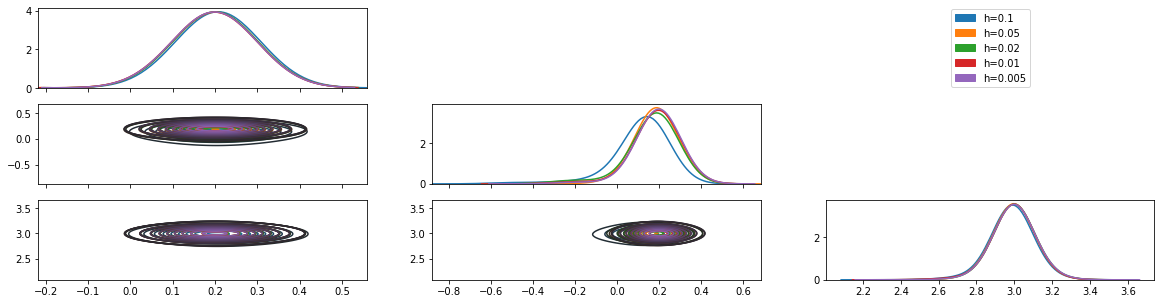

In [95]:
import matplotlib.patches as mpatches
fig, axs = plt.subplots(n_theta, n_theta, sharex='col', figsize=(20, 5))
patches = [None]*n_h
for i in range(n_h):
    patches[i] = mpatches.Patch(color='C{}'.format(i), label='h={}'.format(h[i]))
    for row in range(n_theta):
        sns.kdeplot(fitz_proph[i, :, row], bw=.1, ax=axs[row, row])
        for col in range(row):
            sns.kdeplot(fitz_proph[i, :, col], fitz_proph[i, :, row], bw=.1, ax=axs[row, col])
            
axs[0,1].set_axis_off()
axs[0,2].set_axis_off()
axs[1,2].set_axis_off()
axs[0,2].legend(handles=patches, loc='center')
plt.show()